How to Run the Code:

Load your images:

- Under the line image_files, replace the paths "/content/20250106_104906.jpg" and "/content/20250106_104912.jpg" with the paths to your own images. These will be the images you want to stitch together.

Assign the reference image:

- In the line reference_image_middle, replace "/content/20250106_104909.jpg" with the path to your reference image. This should be the image that is positioned in the middle of your panorama (or the image around which other images will be stitched).

Run the code:

- After loading and assigning the correct paths for your images and reference image, run the code.

Output:

- The final stitched result will be displayed, and it will automatically be saved as panorama_image_1.jpg in your working directory.

# Final Algorithm

In [ ]:
#Load the needed libraries
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

#Definition to process all the images and stitch them into one
def stitch_images_panorama(images, reference_image):
 #Create a definition for scaling the images. I had to scale the images down due to collab crashing with the originally sized images
  def scale_image(image, scale_percent):
    #We calculate the dimensions of our scaled image, by differently calculating the width and height
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    #Defining the dimension argument
    dim = (width, height)
    #Resizing the image to the new size
    resized_image = cv2.resize(image, dim)
    return resized_image

  def detect_and_match_features(img1, img2):
    #Convert second image to grayscale
    orb = cv2.ORB_create(nfeatures=2000) #The maximum number of features to be detected
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None) #reference image
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
    #Finding matches metween the two images
    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.match(descriptors1, descriptors2)
    matches = bf.knnMatch(descriptors1, descriptors2,k=2)

    #Finding the strong matches with Lowe's ratio test
    #Finding the best matches
    good = []
    for m, n in matches:
      if m.distance < 0.6 * n.distance:
          good.append(m)

    #debugging
    print(f"Number of good matches: {len(good)}")
    if len(good) < 10:
      print("Not enough matches to compute homography.")

    return keypoints1, keypoints2, matches, good


  #Estimate homography
  def estimate_homography(keypoints1, keypoints2, matches, good):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    #Find the homography matrix, adjusting based on stitching directio
    M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    #debugging
    if M is None:
      print("Failed to compute homography.")
    else:
      print(f"Homography Matrix:\n{M}")
    return M



  def warp_images(img1, img2, M):
    #Number of rows (height) and columns (width) of the images.
    rows1, cols1 = img1.shape[:2] #Ref image
    rows2, cols2 = img2.shape[:2]

    #List of corner points in the reference image
    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    #List of points in the image that will be transformed
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    #When we have established a homography we need to warp perspective
    #Transformed corner points of img2. Map the points into a new space
    list_of_points_2 = cv2.perspectiveTransform(temp_points, M)
    #Combines the corner points of the reference image with the second image
    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)
    #The smallest x and y values from all corner points. These define the top-left corner of the bounding box.
    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    #The largest x and y values from all corner points. These define the bottom-right corner of the bounding box.
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    #Adjust translation. In the default code this value was setting the coordinates to never be negative. But this image is on the right
    translation_dist = [-x_min,-y_min]
    #Translation matrix that adds the offset
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    #Warp the secondary image
    output_img = cv2.warpPerspective(img2, H_translation.dot(M), (x_max-x_min, y_max-y_min))
    #Place image into the canvas
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img


  #Scale ref image
  reference_image = scale_image(reference_image, 50)

  #Debugging
  print("Images number", len(images))

  #Stitch images to the left of the reference image
  for i in range(len(images) - 1, -1, -1):
    #Scaling down the image
    imge2 = scale_image(images[i], 50)
    #Converting our soon to be stitched image into grayscale for computing
    img2 = cv2.cvtColor(imge2, cv2.COLOR_BGR2GRAY)
    #Grayscaling the reference image each iteration so the final result is a coloured image. But we use grayscale for processing the keypoints and matches
    ref_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
    #Detect the features and finding matches between the two images
    keypoints1, keypoints2, matches, good = detect_and_match_features(ref_image, img2)
    #Calculating the homography
    M = estimate_homography(keypoints1, keypoints2, matches, good)
    #Stitching with coloured images
    reference_image = warp_images(reference_image, imge2, M)  #Stitch imge2 to the left of the coloured reference image.


  #Stitch images to the right of the reference image
  for i in range(1, len(images)):
    imge2 = scale_image(images[i], 50)
    img2 = cv2.cvtColor(imge2, cv2.COLOR_BGR2GRAY)
    #Grayscaling the reference image each iteration so the final result is a coloured image. But we use grayscale for processing the keypoints and matches
    ref_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
    keypoints1, keypoints2, matches, good = detect_and_match_features(ref_image, img2)
    M = estimate_homography(keypoints1, keypoints2, matches, good)
    reference_image = warp_images(reference_image, imge2, M)  #Stitch img2 to the right of img1


  return reference_image



#Load all images
if __name__ == "__main__":
  #image path
  image_files = ["/content/20250106_104906.jpg", "/content/20250106_104912.jpg"]
  images = [cv2.imread(img) for img in image_files]
  reference_image_middle = cv2.imread("/content/20250106_104909.jpg")

  #Debugging
  if reference_image_middle is None:
    print("Error loading reference image.")

  #Debugging
  for img_path, img in zip(image_files, images):
    if img is None:
        print(f"Error loading image: {img_path}")
    else:
        print(f"Successfully loaded: {img_path}")

  try:
    #Make panorama picture
    panorama_image = stitch_images_panorama(images, reference_image_middle)

    #Display the panorama image
    cv2_imshow(panorama_image)

    #Save the image
    cv2.imwrite("panorama_image_1.jpg", panorama_image)

  except Exception as e:
      print("Error", e)


# Example: Final Algorithm + 3 images, grayscale

Successfully loaded: /content/1.jpg
Successfully loaded: /content/3.jpg
Images number 2
Number of good matches: 96
Homography Matrix:
[[ 7.63910735e-01 -1.78478204e-02  1.03218969e+02]
 [-1.36127099e-01  9.00906424e-01  1.28616815e+01]
 [-9.72576390e-04 -8.42119839e-05  1.00000000e+00]]
Number of good matches: 36
Homography Matrix:
[[ 1.58132925e+00  1.16968652e-02 -2.09676572e+02]
 [ 4.59991808e-01  1.47189835e+00 -4.79310885e+01]
 [ 2.57949660e-03  7.69489898e-06  1.00000000e+00]]
Number of good matches: 188
Homography Matrix:
[[ 5.73247818e-01 -1.31891094e-02  3.11930008e+02]
 [-2.07167823e-01  9.21399180e-01  8.45054398e+01]
 [-9.72414225e-04 -2.92863187e-05  1.00000000e+00]]


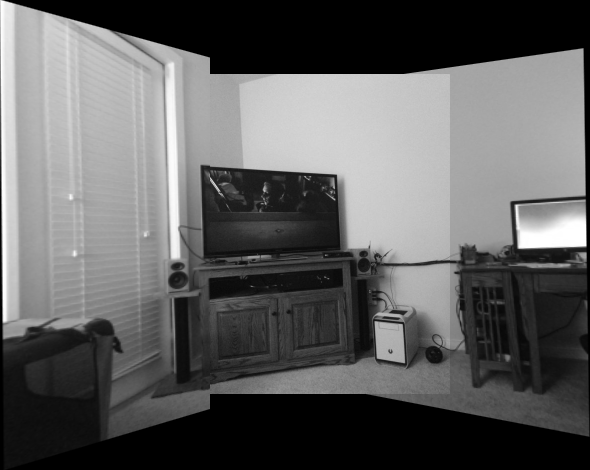

In [ ]:
#Load the needed libraries
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def stitch_images_panorama(images, reference_image):
 #Create a definition for scaling the images
  def scale_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(image, dim)
    return resized_image

  def detect_and_match_features(img1, img2):
    #Convert second image to grayscale
    orb = cv2.ORB_create(nfeatures=2000) #The maximum number of features to be detected
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None) #reference image
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING)
    matches = bf.match(descriptors1, descriptors2)
    matches = bf.knnMatch(descriptors1, descriptors2,k=2)

    #Finding the strong matches with Lowe's ratio test
    #Finding the best matches
    good = []
    for m, n in matches:
      if m.distance < 0.6 * n.distance:
          good.append(m)

    #debugging
    print(f"Number of good matches: {len(good)}")
    if len(good) < 10:
      print("Not enough matches to compute homography.")

    return keypoints1, keypoints2, matches, good


  #Estimate homography
  def estimate_homography(keypoints1, keypoints2, matches, good):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    #Find the homography matrix, adjusting based on stitching directio
    M, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    #debugging
    if M is None:
      print("Failed to compute homography.")
    else:
      print(f"Homography Matrix:\n{M}")
    return M



  def warp_images(img1, img2, M):
    #Number of rows (height) and columns (width) of the images.
    rows1, cols1 = img1.shape[:2] #Ref image
    rows2, cols2 = img2.shape[:2]

    #List of corner points in the reference image
    list_of_points_1 = np.float32([[0,0], [0, rows1],[cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    #List of points in the image that will be transformed
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)

    #When we have established a homography we need to warp perspective
    #Transformed corner points of img2. Map the points into a new space
    list_of_points_2 = cv2.perspectiveTransform(temp_points, M)
    #Combines the corner points of the reference image with the second image
    list_of_points = np.concatenate((list_of_points_1,list_of_points_2), axis=0)
    #The smallest x and y values from all corner points. These define the top-left corner of the bounding box.
    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    #The largest x and y values from all corner points. These define the bottom-right corner of the bounding box.
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    #Adjust translation. In the default code this value was setting the coordinates to never be negative. But this image is on the right
    translation_dist = [-x_min,-y_min]
    #Translation matrix that adds the offset
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])
    #Warp the secondary image
    output_img = cv2.warpPerspective(img2, H_translation.dot(M), (x_max-x_min, y_max-y_min))
    #Place image into the canvas
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1

    return output_img



  #Scale ref image and grayscale it
  reference_image = scale_image(reference_image, 50)
  ref_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)

  #Debugging
  print("Images number", len(images))

  #Stitch images to the left of the reference image
  for i in range(len(images) - 1, -1, -1):
    imge2 = scale_image(images[i], 50)
    img2 = cv2.cvtColor(imge2, cv2.COLOR_BGR2GRAY)
    keypoints1, keypoints2, matches, good = detect_and_match_features(ref_image, img2)
    M = estimate_homography(keypoints1, keypoints2, matches, good)
    ref_image = warp_images(ref_image, img2, M)  #Stitch img2 to the left of img1

  #Stitch images to the right of the reference image
  for i in range(1, len(images)):
    imge2 = scale_image(images[i], 50)
    img2 = cv2.cvtColor(imge2, cv2.COLOR_BGR2GRAY)
    keypoints1, keypoints2, matches, good = detect_and_match_features(ref_image, img2)
    M = estimate_homography(keypoints1, keypoints2, matches, good)
    ref_image = warp_images(ref_image, img2, M)  #Stitch img2 to the right of img1

  return ref_image



#Load all images
if __name__ == "__main__":
  #image path
  image_files = ["/content/1.jpg", "/content/3.jpg"]
  images = [cv2.imread(img) for img in image_files]
  reference_image_middle = cv2.imread("/content/2.jpg")

  #Debugging
  #cv2_imshow(images[0])
  #cv2_imshow(images[1])
  #cv2_imshow(reference_image_middle)

  #Debugging
  if reference_image_middle is None:
    print("Error loading reference image.")

  #Debugging
  for img_path, img in zip(image_files, images):
    if img is None:
        print(f"Error loading image: {img_path}")
    else:
        print(f"Successfully loaded: {img_path}")

  try:
    #Make panorama picture
    panorama_image = stitch_images_panorama(images, reference_image_middle)

    #Display the panorama image
    cv2_imshow(panorama_image)

    #Save the image
    cv2.imwrite("panorama_image_2.jpg", panorama_image)

  except Exception as e:
      print("Error", e)
